## <center> Assignment 4. Sarcasm detection with logistic regression
    
We'll be using the dataset from the [paper](https://arxiv.org/abs/1704.05579) "A Large Self-Annotated Corpus for Sarcasm" with >1mln comments from Reddit, labeled as either sarcastic or not. A processed version can be found on Kaggle in a form of a [Kaggle Dataset](https://www.kaggle.com/danofer/sarcasm).

Sarcasm detection is easy. 

<img src="https://habrastorage.org/webt/1f/0d/ta/1f0dtavsd14ncf17gbsy1cvoga4.jpeg" />

### **Introducción**

En este trabajo, analizaremos un conjunto de datos extraido del sitio web de comentarios de Reddit.
El objetivo principal es detectar si un comentario es sarcástico o no.
La target es la columna 'label' que indicará si el comentario e sarcástico con un 1 y si no es sárcastico con un 0.


Por lo que utilizaremos el modelo de regresión logística para predecir los valores y nos valdremos de las técnicas NLP para tratar los comentarios de la columna 'comment'.

### **Librerías**

In [2]:
# some necessary imports
import os
import re
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from collections import defaultdict
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.offline as py
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

### **Carga de datos**

In [3]:
df = pd.read_csv('../dataNLP/Prof/train-balanced-sarcasm.csv')

### **Primera exploración**

In [4]:
df.head()

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...


In [5]:
df.tail()

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
1010821,1,I'm sure that Iran and N. Korea have the techn...,TwarkMain,reddit.com,2,2,0,2009-04,2009-04-25 00:47:52,"No one is calling this an engineered pathogen,..."
1010822,1,"whatever you do, don't vote green!",BCHarvey,climate,1,1,0,2009-05,2009-05-14 22:27:40,In a move typical of their recent do-nothing a...
1010823,1,Perhaps this is an atheist conspiracy to make ...,rebelcommander,atheism,1,1,0,2009-01,2009-01-11 00:22:57,Screw the Disabled--I've got to get to Church ...
1010824,1,The Slavs got their own country - it is called...,catsi,worldnews,1,1,0,2009-01,2009-01-23 21:12:49,I've always been unsettled by that. I hear a l...
1010825,1,"values, as in capitalism .. there is good mone...",frogking,politics,2,2,0,2009-01,2009-01-24 06:20:14,Why do the people who make our laws seem unabl...


In [6]:
df.shape

(1010826, 10)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1010826 entries, 0 to 1010825
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   label           1010826 non-null  int64 
 1   comment         1010771 non-null  object
 2   author          1010826 non-null  object
 3   subreddit       1010826 non-null  object
 4   score           1010826 non-null  int64 
 5   ups             1010826 non-null  int64 
 6   downs           1010826 non-null  int64 
 7   date            1010826 non-null  object
 8   created_utc     1010826 non-null  object
 9   parent_comment  1010826 non-null  object
dtypes: int64(4), object(6)
memory usage: 77.1+ MB


In [8]:
df.duplicated().sum()

28

In [9]:
df.isna().sum()

label              0
comment           55
author             0
subreddit          0
score              0
ups                0
downs              0
date               0
created_utc        0
parent_comment     0
dtype: int64

In [10]:
df.describe(exclude='object').round(2)

,label,score,ups,downs
count,1010826.0,1010826.00,1010826.00,1010826.00
mean,0.5,6.89,5.50,-0.15
std,0.5,48.34,41.27,0.35
min,0.0,-507.00,-507.00,-1.00
25%,0.0,1.00,0.00,0.00
50%,0.5,2.00,1.00,0.00
75%,1.0,4.00,3.00,0.00
max,1.0,9070.00,5163.00,0.00


### **Limpieza**

Eliminaremos las observaciones que corresponden a los 55 valores de la columna 'comment' que es la que vamos a analizar para detectar el sarcasmo

In [11]:
df.dropna(inplace=True)

Eliminaremos los valores duplicados del dataframe en función de los valores duplicados de la columna 'comment'

In [12]:
df.drop_duplicates(subset = 'comment', inplace=True)

In [13]:
df.shape

(962293, 10)

A continuación eliminaremos todos los carácteres no alfanuméricos perservando los espacios en la columna 'comment'

In [14]:
def alfanumericos(comment):
    return re.sub(r'[^\w\s]', '', comment)

df['comment'] = df['comment'].apply(alfanumericos)

In [15]:
df['comment'].head()

0                                            NC and NH
1    You do know west teams play against west teams...
2    They were underdogs earlier today but since Gr...
3    This meme isnt funny none of the new york nigg...
4                       I could use one of those tools
Name: comment, dtype: object

### **EDA**

In [16]:
#Función para visualización
def grafico_countplot(column,df):

    custom_palette = sns.color_palette("husl", len(df[column].unique()))
    sns.countplot(x=column, hue=column, data=df, palette=custom_palette, stat='percent')

    return plt.show()

Visualizamos nuestra target 'label'

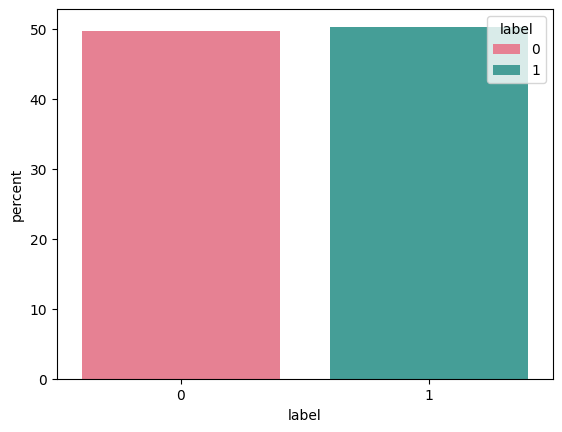

In [17]:
grafico_countplot('label',df)

In [18]:
df['label'].value_counts()

label
1    484099
0    478194
Name: count, dtype: int64

Observamos que la target está balanceada.

**Nube de palabras:** Ahora veamos las palabras que aparecen con frecuencia en los datos creando una nube de palabras en la columna 'comment'

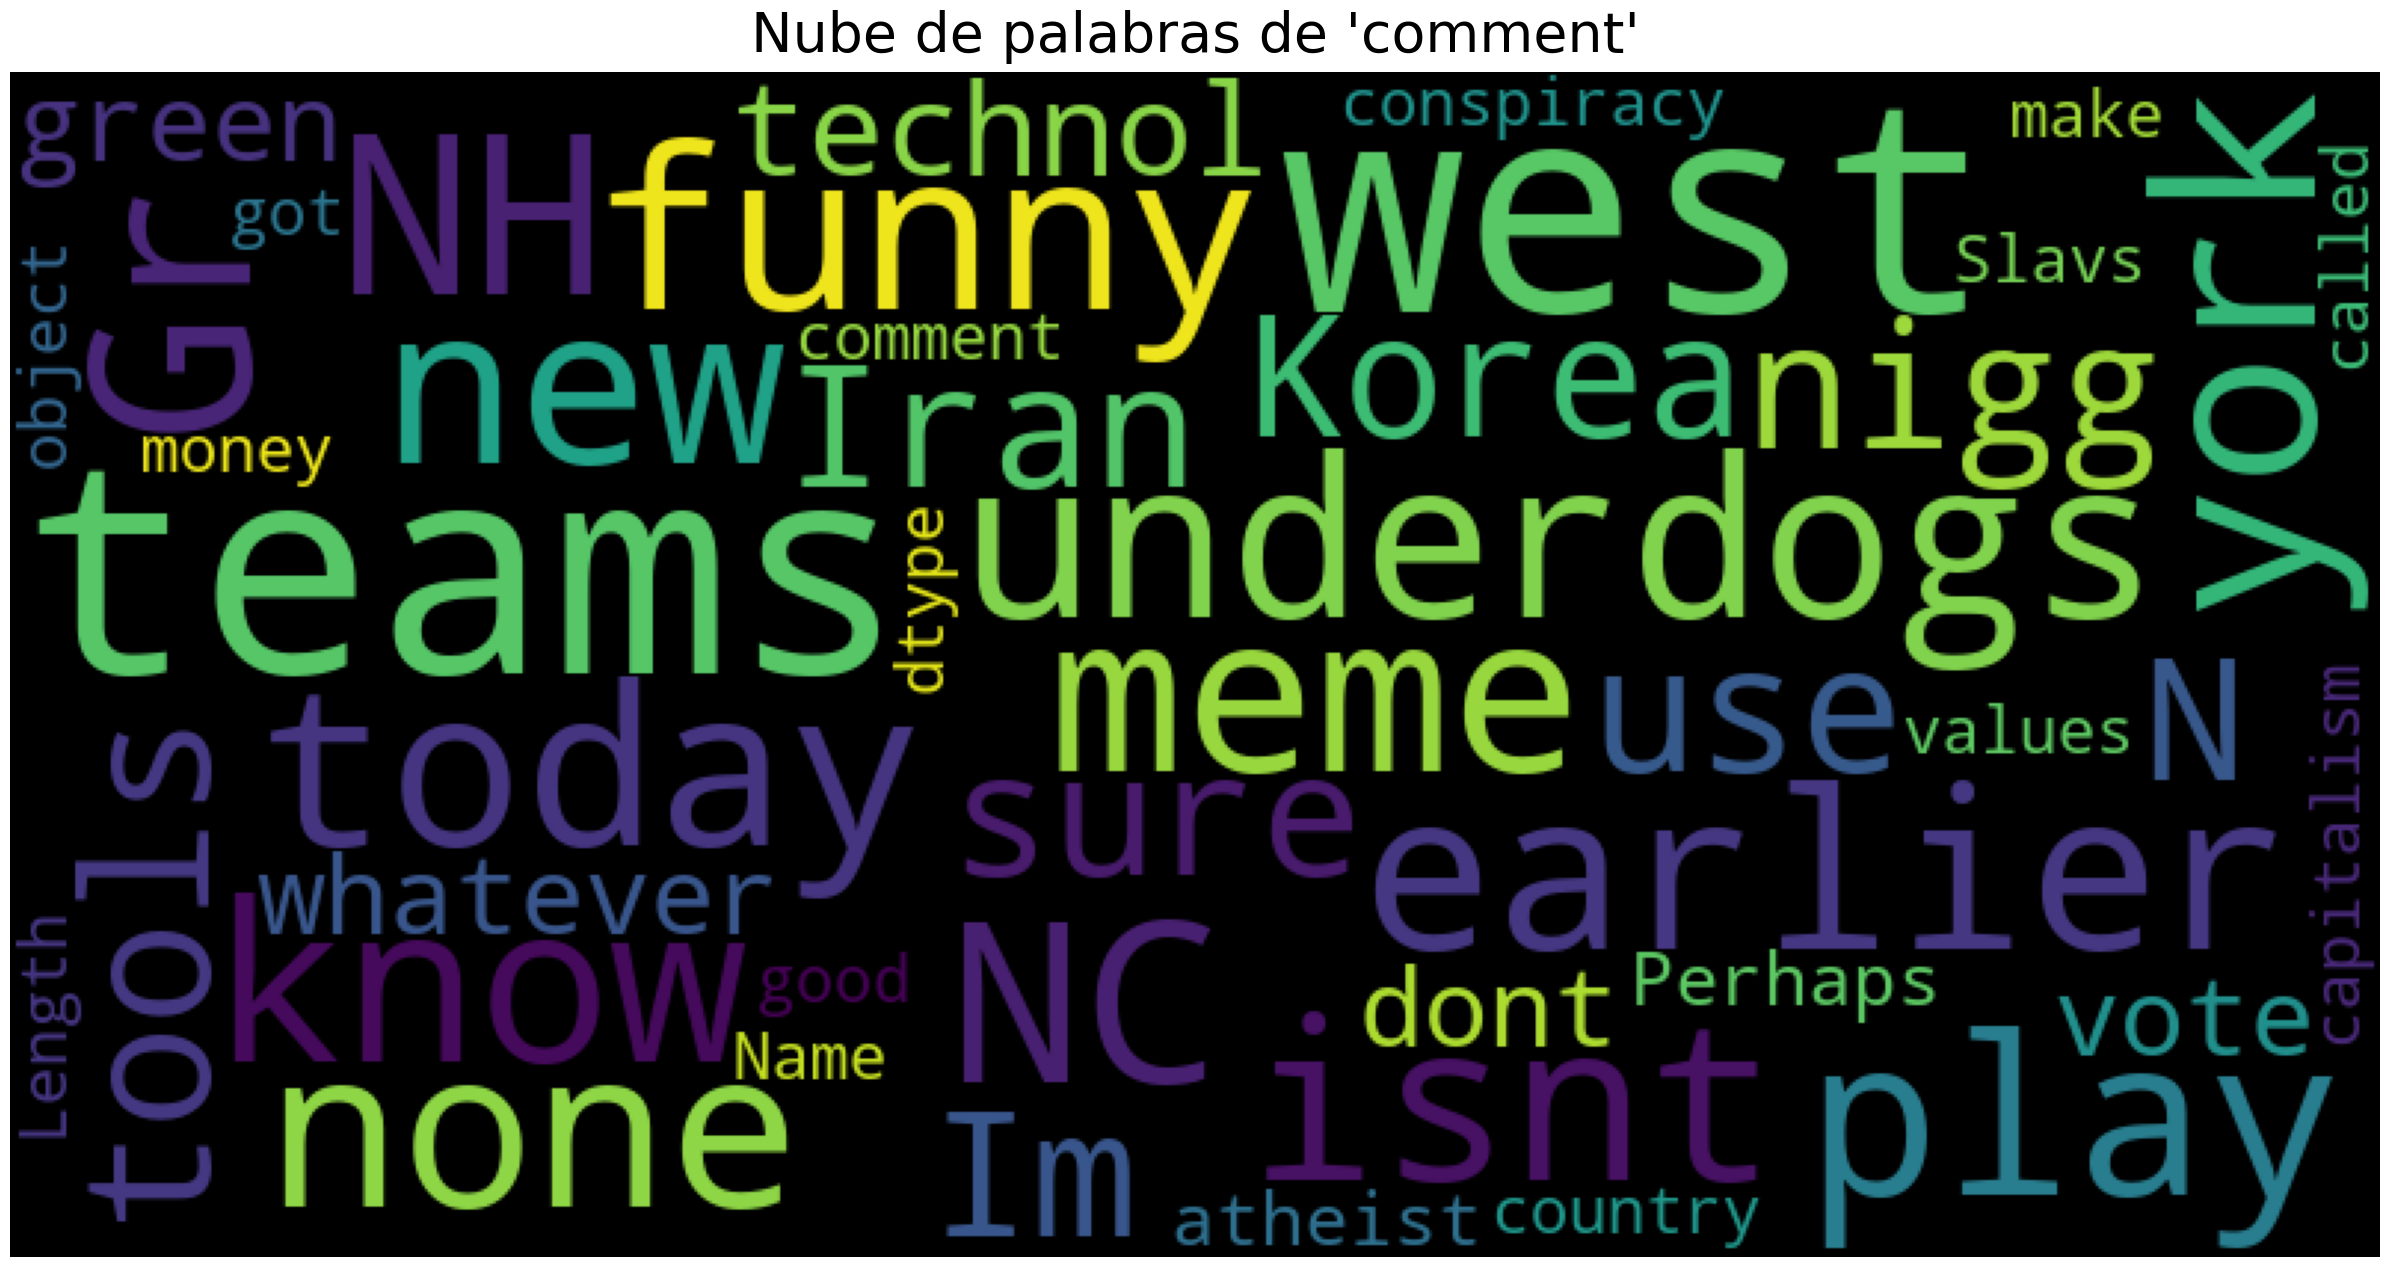

In [19]:
def plot_wordcloud(text, mask=None, max_words=200, max_font_size=100, figure_size=(24.0,16.0), 
                   title = None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)
    more_stopwords = {'one', 'br', 'Po', 'th', 'sayi', 'fo', 'Unknown'}
    stopwords = stopwords.union(more_stopwords)

    wordcloud = WordCloud(background_color='black',
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    width=800, 
                    height=400,
                    mask = mask)
    wordcloud.generate(str(text))
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()  
    
plot_wordcloud(df["comment"], title="Nube de palabras de 'comment'")

A continuación miraremos las palabras más frecuentes en cada una de las clases por separado

**Gráficos de recuento de palabras**

In [20]:
df1 = df[df["label"]==1]
df0 = df[df["label"]==0]

## custom function for ngram generation ##
def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(" ") if token != "" if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [" ".join(ngram) for ngram in ngrams]

## custom function for horizontal bar chart ##
def horizontal_bar_chart(df, color):
    trace = go.Bar(
        y=df["word"].values[::-1],
        x=df["wordcount"].values[::-1],
        showlegend=False,
        orientation = 'h',
        marker=dict(
            color=color,
        ),
    )
    return trace

## Get the bar chart from sincere questions ##
freq_dict = defaultdict(int)
for sent in df0["comment"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(50), 'green')

## Get the bar chart from insincere questions ##
freq_dict = defaultdict(int)
for sent in df1["comment"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(50), 'purple')

# Creating two subplots
fig = make_subplots(rows=1, cols=2, vertical_spacing=0.04,
                          subplot_titles=["Palabras frecuentes en comment no sarcásticos", 
                                          "Palabras freceuntes en comment sarcásticos"])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig['layout'].update(height=1200, width=900, paper_bgcolor='rgb(233,233,233)', title="Word Count Plots")
py.iplot(fig, filename='word-plots')

Algunas de las palabras principales son comunes en ambas clases, como dont, people, well...

**Gráficos de frecuencia de bigramas**

In [21]:
freq_dict = defaultdict(int)
for sent in df0["comment"]:
    for word in generate_ngrams(sent,2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(50), 'green')


freq_dict = defaultdict(int)
for sent in df1["comment"]:
    for word in generate_ngrams(sent,2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(50), 'purple')

# Creating two subplots
fig = make_subplots(rows=1, cols=2, vertical_spacing=0.04,horizontal_spacing=0.15,
                          subplot_titles=["Bigramas frecuentes de comment no sarcásticos", 
                                          "Bigramas frecuentes de comment sarcásticos"])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig['layout'].update(height=1200, width=900, paper_bgcolor='rgb(233,233,233)', title="Bigram Count Plots")
py.iplot(fig, filename='word-plots')

Observamos que 'dont know', 'im sure' son frecuentes en ambas clases.


**Gráficos de recuento de trigramas**

In [22]:
freq_dict = defaultdict(int)
for sent in df0["comment"]:
    for word in generate_ngrams(sent,3):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(50), 'green')


freq_dict = defaultdict(int)
for sent in df1["comment"]:
    for word in generate_ngrams(sent,3):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(50), 'purple')

# Creating two subplots
fig = make_subplots(rows=1, cols=2, vertical_spacing=0.04, horizontal_spacing=0.2,
                          subplot_titles=["Trigramas frecuentes de comment no sarcásticos", 
                                          "Trigramas frecuentes de comment sarcásticos"])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig['layout'].update(height=1200, width=1200, paper_bgcolor='rgb(233,233,233)', title="Trigram Count Plots")
py.iplot(fig, filename='word-plots')

A continuación estudiaremos algunas características y observaremos como se distribuyen en las clases con un boxplot

* Número de palabras en el texto.


* Número de palabras únicas en el texto.


* Número de caracteres en el texto.


* Número de palabras en mayúsculas


* Longitud media de las palabras.

In [23]:
#Copia para visualizacion
df_copy=df.copy()

In [24]:
## Number of words in the text
df_copy["num_words"] = df_copy["comment"].apply(lambda x: len(str(x).split()))

In [25]:
## Number of unique words in the text
df_copy["num_unique_words"] = df_copy["comment"].apply(lambda x: len(set(str(x).split())))

In [26]:

## Number of characters in the text
df_copy["num_chars"] = df_copy["comment"].apply(lambda x: len(str(x)))

In [27]:
## Number of title case words in the text
df_copy["num_words_upper"] = df_copy["comment"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

In [28]:
## Average length of the words in the text
df_copy["mean_word_len"] = df_copy["comment"].apply(lambda x: np.mean([len(w) for w in str(x).split()]) if str(x).split() else 0)

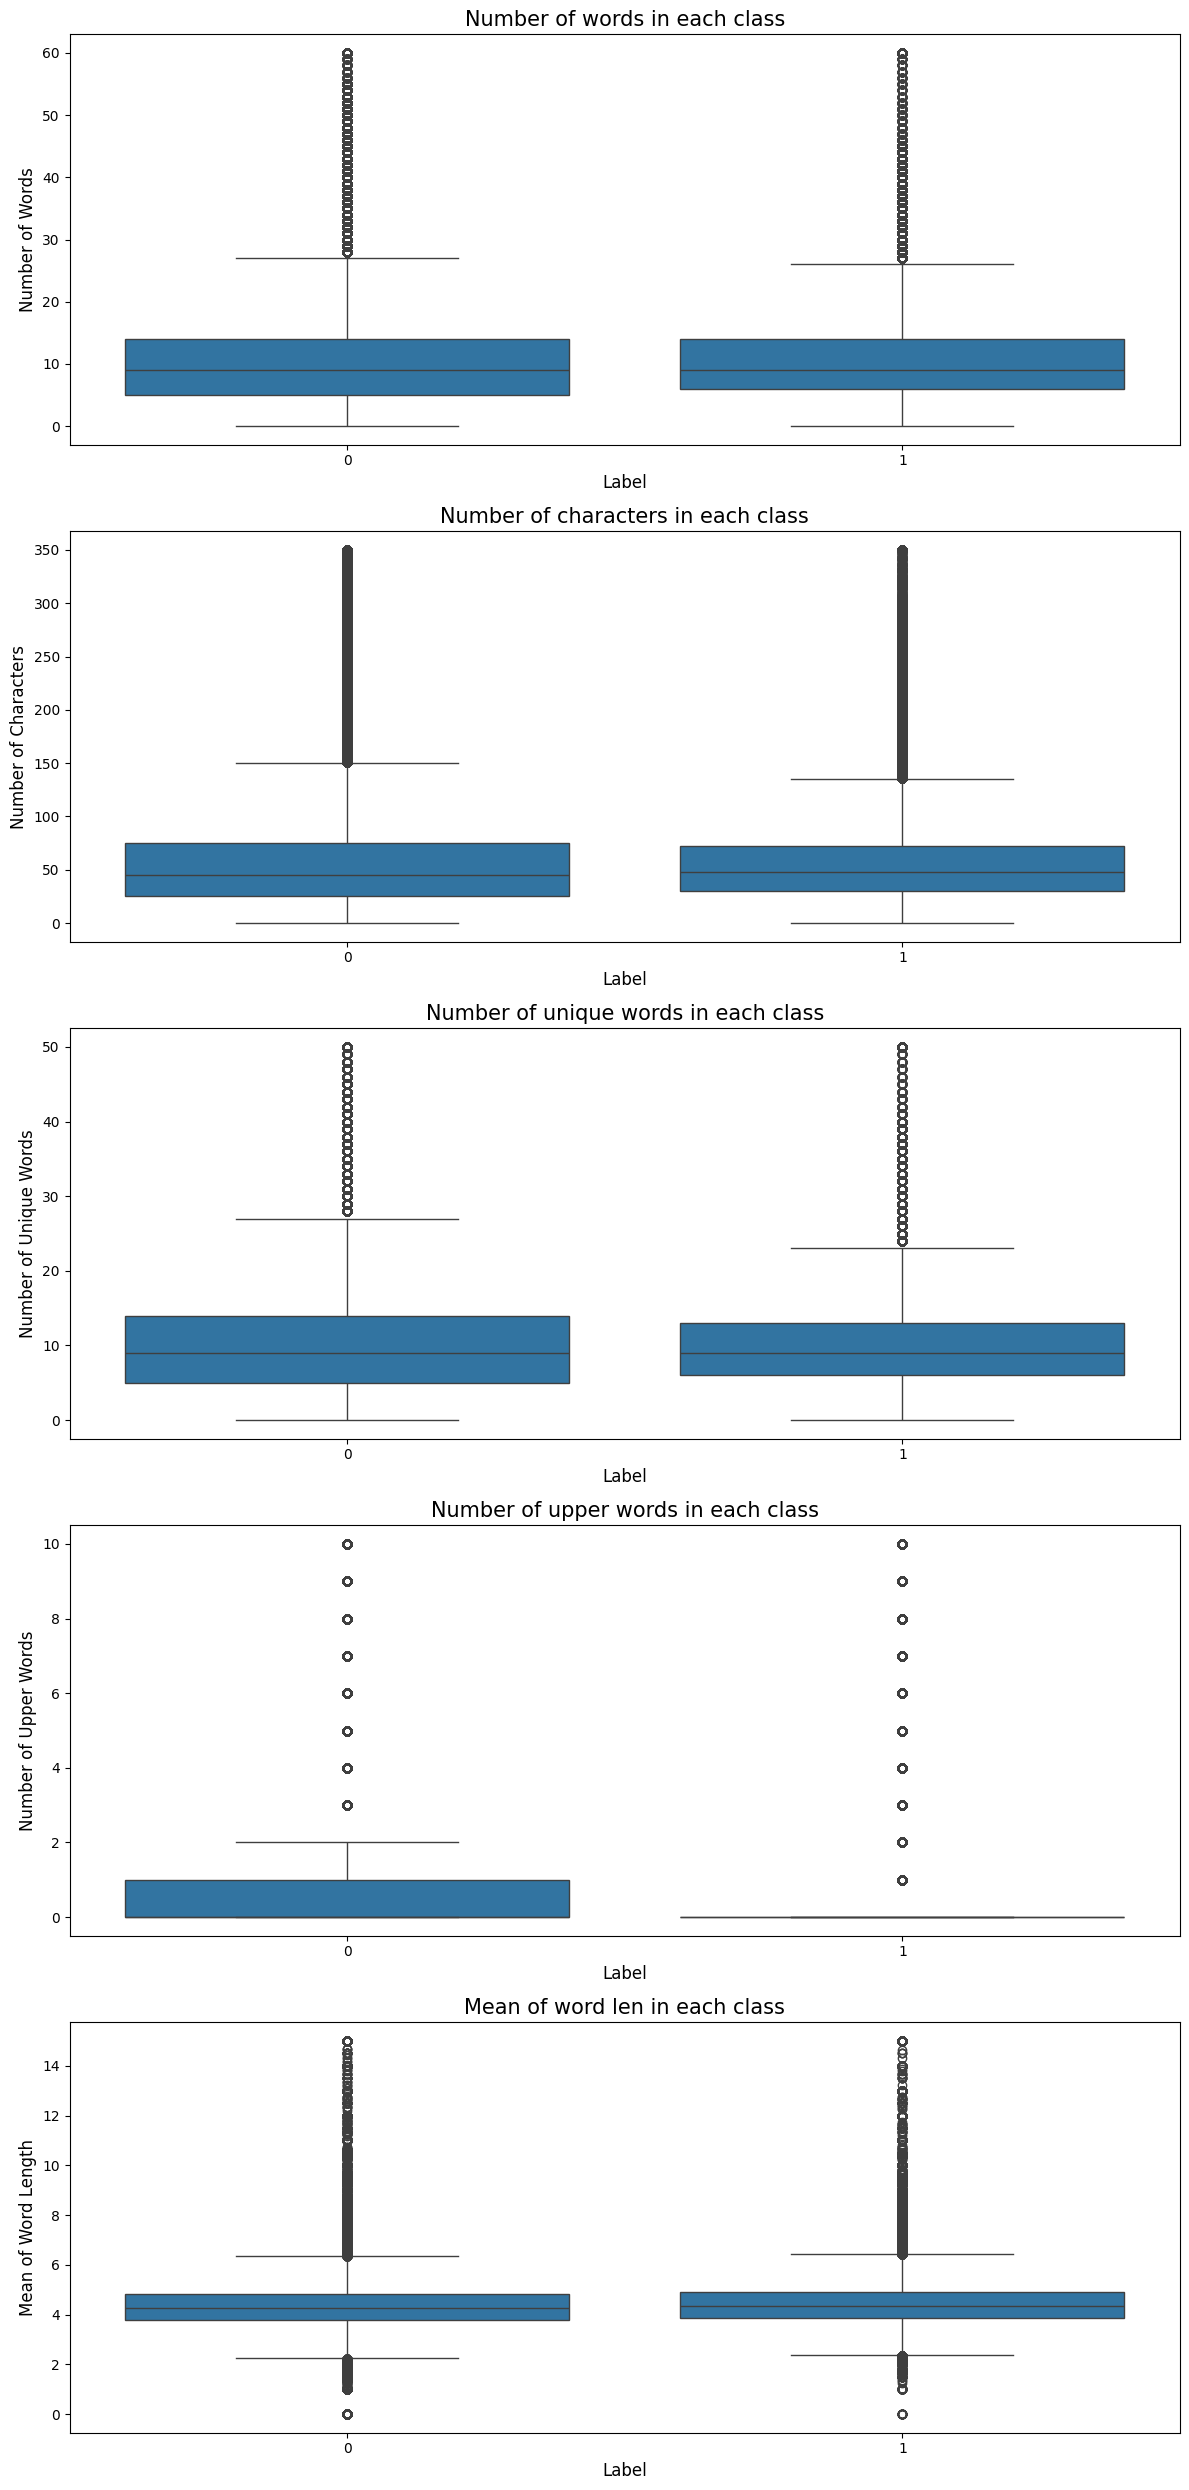

In [29]:
# Truncar valores para mejores visualizaciones
df_copy.loc[df_copy['num_words'] > 60, 'num_words'] = 60 
df_copy.loc[df_copy['num_chars'] > 350, 'num_chars'] = 350 
df_copy.loc[df_copy['num_unique_words'] > 50, 'num_unique_words'] = 50 
df_copy.loc[df_copy['num_words_upper'] > 10, 'num_words_upper'] = 10 
df_copy.loc[df_copy['mean_word_len'] > 15, 'mean_word_len'] = 15 

f, axes = plt.subplots(5, 1, figsize=(12, 25))

sns.boxplot(x='label', y='num_words', data=df_copy, ax=axes[0])
axes[0].set_xlabel('Label', fontsize=12)
axes[0].set_ylabel('Number of Words', fontsize=12)
axes[0].set_title("Number of words in each class", fontsize=15)

sns.boxplot(x='label', y='num_chars', data=df_copy, ax=axes[1])
axes[1].set_xlabel('Label', fontsize=12)
axes[1].set_ylabel('Number of Characters', fontsize=12)
axes[1].set_title("Number of characters in each class", fontsize=15)

sns.boxplot(x='label', y='num_unique_words', data=df_copy, ax=axes[2])
axes[2].set_xlabel('Label', fontsize=12)
axes[2].set_ylabel('Number of Unique Words', fontsize=12)
axes[2].set_title("Number of unique words in each class", fontsize=15)

sns.boxplot(x='label', y='num_words_upper', data=df_copy, ax=axes[3])
axes[3].set_xlabel('Label', fontsize=12)
axes[3].set_ylabel('Number of Upper Words', fontsize=12)
axes[3].set_title("Number of upper words in each class", fontsize=15)

sns.boxplot(x='label', y='mean_word_len', data=df_copy, ax=axes[4])
axes[4].set_xlabel('Label', fontsize=12)
axes[4].set_ylabel('Mean of Word Length', fontsize=12)
axes[4].set_title("Mean of word len in each class", fontsize=15)

plt.tight_layout()

plt.show()

### **Modelo**

**División del dataset**

In [30]:
#División dataset----> train y test
train_set, test_set= train_test_split(df, test_size=0.2, random_state=42)

#División train_set---> train y validation
train, val = train_test_split(train_set, test_size=0.2, random_state=42)

# Separar características y etiquetas para conjunto de entrenamiento
X_train = train['comment']
y_train = train['label']

# Separar características y etiquetas para conjunto de validación
X_val = val['comment']
y_val = val['label']

# Separar características y etiquetas para conjunto de prueba
X_test = test_set['comment']
y_test = test_set['label']

In [31]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(615867,)
(615867,)
(153967,)
(153967,)
(192459,)
(192459,)


**Eliminamos las stopwords**

In [32]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/itziarc/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [33]:
stopwords_en = stopwords.words('english')

In [34]:
def remove_stopwords(df):
    return " ".join([word for word in df.split() if word not in stopwords_en])

In [35]:
X_train = X_train.apply(remove_stopwords)
X_train.head()

23808                                          Ashens would
616457                                                Fatty
184505    If poison air chemtrails cause droughts benefi...
124297                              anti cheat shit tourney
168409         I thought post prison season 4 episodes peak
Name: comment, dtype: object

In [36]:
X_val = X_val.apply(remove_stopwords)
X_test = X_test.apply(remove_stopwords)

**Aplicamos Snowball**

In [37]:
def stemmer_en(x):
    stemmer = SnowballStemmer('english')
    return " ".join([stemmer.stem(word) for word in x.split()])

In [38]:
X_train=X_train.apply(stemmer_en)
X_val=X_val.apply(stemmer_en)
X_test=X_test.apply(stemmer_en)

**Vectorizamos el dataset y aplicamos regresión logística con un Pipeline**

In [39]:
tf_f=TfidfVectorizer(ngram_range=(1,2))
lr=LogisticRegression()
pipeline= Pipeline([('tf_f',tf_f),('lr',lr)])

**Entrenamiento**

In [40]:
pipeline.fit(X_train,y_train)

Pipeline(steps=[('tf_f', TfidfVectorizer(ngram_range=(1, 2))),
                ('lr', LogisticRegression())])

**Predicción**

In [41]:
predic = pipeline.predict(X_val)

In [42]:
print(classification_report(y_val, predic))
print("Accuracy Score:", accuracy_score(y_val, predic))

              precision    recall  f1-score   support

           0       0.69      0.71      0.70     76296
           1       0.71      0.69      0.70     77671

    accuracy                           0.70    153967
   macro avg       0.70      0.70      0.70    153967
weighted avg       0.70      0.70      0.70    153967

Accuracy Score: 0.6985587820766788


In [43]:
conf_matrix = confusion_matrix(y_val, predic)
conf_matrix

array([[53922, 22374],
       [24038, 53633]])

**Aplicamos a nuestros datos de test**

In [44]:
predic = pipeline.predict(X_test)

In [45]:
print(classification_report(y_test, predic))
print("Accuracy Score:", accuracy_score(y_test, predic))

              precision    recall  f1-score   support

           0       0.69      0.71      0.70     95501
           1       0.71      0.69      0.70     96958

    accuracy                           0.70    192459
   macro avg       0.70      0.70      0.70    192459
weighted avg       0.70      0.70      0.70    192459

Accuracy Score: 0.6995100255119272


In [46]:
conf_matrix = confusion_matrix(y_test, predic)
conf_matrix

array([[67502, 27999],
       [29833, 67125]])

El modelo predice con accuracy de 0.69 en los datos de test por lo que generaliza bien